This example notebook shows how we can train an [image/digit classification](https://pytorch.org/tutorials/beginner/nn_tutorial.html?highlight=mnist)
model based on MNIST dataset, by employing TileDB as a storage engine for our training data and labels. We will first download the MNIST
dataset and ingest images and labels in two dense TileDB arrays. Continuing, we will use our TileDB support for PyTorch Dataloader API
in order to train a image classifier. First, let's import what we need and download our data.

In [1]:
import os
import idx2numpy
import numpy as np
import tiledb
import torch
import torchvision
import matplotlib.pyplot as plt

Download MNIST dataset.

In [ ]:
data = torchvision.datasets.MNIST('./data', train=False, download=True)

Then we proceed with ingesting images and labels into dense TileDB arrays. Here, we should point out that besides the
flexibility of TileDB in defining a schema, i.e., multiple dimensions, multiple attributes, compression etc,
we choose to define a simple schema. So, for a numpy array of D number of dimensions we create a dense TileDB array,
with the same number of dimensions, and a single attribute of data type numpy float32. Moreover, the
tile extend of the 1st dimension should always be equal with the batch size, in order to achieve optimal reads while
training.

In [3]:
# Let's define an ingestion function
def ingest_in_tiledb(data: np.array, batch_size: int, uri: str):
    # Equal number of dimensions with the numpy array.
    dims = [
        tiledb.Dim(
            name="dim_" + str(dim),
            domain=(0, data.shape[dim] - 1),
            tile=data.shape[dim] if dim > 0 else batch_size,
            dtype=np.int32,
        )
        for dim in range(data.ndim)
    ]

    # TileDB schema
    schema = tiledb.ArraySchema(
        domain=tiledb.Domain(*dims),
        sparse=False,
        attrs=[tiledb.Attr(name="features", dtype=data.dtype)],
    )
    # Create array
    tiledb.Array.create(uri, schema)

    # Ingest
    with tiledb.open(uri, "w") as tiledb_array:
        tiledb_array[:] = {"features": data}

images = idx2numpy.convert_from_file('./data/MNIST/raw/train-images-idx3-ubyte')
labels = idx2numpy.convert_from_file('./data/MNIST/raw/train-labels-idx1-ubyte')

print(images.shape, images.dtype)
print(labels.shape, labels.dtype)

# Ingest images
ingest_in_tiledb(data=images, batch_size=64, uri='training_images')

# Ingest labels
ingest_in_tiledb(data=labels, batch_size=64, uri='training_labels')

(60000, 28, 28) uint8
(60000,) uint8


We can now explore our TileDB arrays and check their structure.

In [4]:
images_array = tiledb.open('training_images')
labels_array = tiledb.open('training_labels')

print(images_array.schema)
print(labels_array.schema)

ArraySchema(
  domain=Domain(*[
    Dim(name='dim_0', domain=(0, 59999), tile=64, dtype='int32'),
    Dim(name='dim_1', domain=(0, 27), tile=28, dtype='int32'),
    Dim(name='dim_2', domain=(0, 27), tile=28, dtype='int32'),
  ]),
  attrs=[
    Attr(name='features', dtype='uint8', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)

ArraySchema(
  domain=Domain(*[
    Dim(name='dim_0', domain=(0, 59999), tile=64, dtype='int32'),
  ]),
  attrs=[
    Attr(name='features', dtype='uint8', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)



We can easily now slice our data and create some plots. We can either slice an image or a part of
an image. Because we use only one attribute, we always slice with attribute with index equal to 0.
Some examples below.

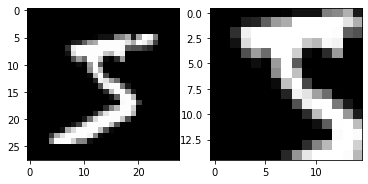

In [5]:
# Plot an image
plt.subplot(1, 2, 1)
plt.imshow(images_array[0][images_array.schema.attr(0).name], cmap="gray")

# Plot part of the same image
plt.subplot(1, 2, 2)
plt.imshow(images_array[0, 5:20, 5:20][images_array.schema.attr(0).name], cmap="gray")

Let's move on and create a TileDB dataset that can be used with PyTorch Dataloader API for training a machine learning
model.

In [6]:
import torch.nn as nn
import torch.optim as optim

from tiledb.ml.readers.pytorch import PyTorchTileDBDenseDataset

class Net(nn.Module):
    def __init__(self, shape):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(np.product(shape), 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

with tiledb.open('training_images') as x, tiledb.open('training_labels') as y:
    tiledb_dataset = PyTorchTileDBDenseDataset(x_array=x, y_array=y, batch_size=64)
    train_loader = torch.utils.data.DataLoader(tiledb_dataset, batch_size=None, num_workers=2)

    net = Net(shape=(28, 28))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

    for epoch in range(1, 5):
        net.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs.to(torch.float))
            loss = criterion(outputs, labels.to(torch.float).type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} Batch: {} Loss: {:.6f}'.format(
                epoch, batch_idx, loss.item()))

Train Epoch: 1 Batch: 0 Loss: 7.687702
Train Epoch: 1 Batch: 100 Loss: 2.296125
Train Epoch: 1 Batch: 200 Loss: 2.309052
Train Epoch: 1 Batch: 300 Loss: 2.306211
Train Epoch: 1 Batch: 400 Loss: 2.302584
Train Epoch: 1 Batch: 500 Loss: 2.303751
Train Epoch: 1 Batch: 600 Loss: 2.301477
Train Epoch: 1 Batch: 700 Loss: 2.304769
Train Epoch: 1 Batch: 800 Loss: 2.303296
Train Epoch: 1 Batch: 900 Loss: 2.305067
Train Epoch: 2 Batch: 0 Loss: 2.304070
Train Epoch: 2 Batch: 100 Loss: 2.296437
Train Epoch: 2 Batch: 200 Loss: 2.304955
Train Epoch: 2 Batch: 300 Loss: 2.303070
Train Epoch: 2 Batch: 400 Loss: 2.301398
Train Epoch: 2 Batch: 500 Loss: 2.303047
Train Epoch: 2 Batch: 600 Loss: 2.301500
Train Epoch: 2 Batch: 700 Loss: 2.304181
Train Epoch: 2 Batch: 800 Loss: 2.303619
Train Epoch: 2 Batch: 900 Loss: 2.304685
Train Epoch: 3 Batch: 0 Loss: 2.303850
Train Epoch: 3 Batch: 100 Loss: 2.297058
Train Epoch: 3 Batch: 200 Loss: 2.304744
Train Epoch: 3 Batch: 300 Loss: 2.303025
Train Epoch: 3 Batch: 